# Transfer Learning on Skin Cancer MNIST: HAM10000
Dataset: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/downloads/skin-cancer-mnist-ham10000.zip/2

In [0]:
!cp /content/kaggle.json /content/.kaggle/kaggle.json
!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 2.61G/2.62G [00:34<00:00, 49.1MB/s]
100% 2.62G/2.62G [00:34<00:00, 82.0MB/s]


In [10]:
!unzip  "skin-cancer-mnist-ham10000.zip"

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: hmnist_28_28_RGB.csv    
  inflating: HAM10000_metadata.csv   
  inflating: HAM10000_images_part_1.zip  
  inflating: hmnist_28_28_L.csv      
  inflating: hmnist_8_8_L.csv        
  inflating: HAM10000_images_part_2.zip  
  inflating: hmnist_8_8_RGB.csv      


# 

In [0]:
!mkdir ham10000_images_part

In [0]:
!chmod 600 HAM10000_images_part_*
!unzip HAM10000_images_part_2.zip -d ham10000_images_part
!unzip HAM10000_images_part_1.zip -d ham10000_images_part

## Train model

### Import all useful libraries

In [0]:
import os
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


### Generate training data

In [0]:
# Create a new directory
base_dir = 'base_dir'
if not os.path.exists(base_dir):
  os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
if not os.path.exists(train_dir):
  os.mkdir(train_dir)

#

val_dir = os.path.join(base_dir, 'val_dir')
if not os.path.exists(val_dir):
  os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
if not os.path.exists(nv):
  os.mkdir(nv)
  
mel = os.path.join(train_dir, 'mel')
if not os.path.exists(mel):
  os.mkdir(mel)
  
bkl = os.path.join(train_dir, 'bkl')
if not os.path.exists(bkl):
  os.mkdir(bkl)

bcc = os.path.join(train_dir, 'bcc')
if not os.path.exists(bcc):
  os.mkdir(bcc)
  
akiec = os.path.join(train_dir, 'akiec')
if not os.path.exists(akiec):
  os.mkdir(akiec)

vasc = os.path.join(train_dir, 'vasc')
if not os.path.exists(vasc):
  os.mkdir(vasc)
  
df = os.path.join(train_dir, 'df')
if not os.path.exists(df):
  os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')

if not os.path.exists(nv):
  os.mkdir(nv)

mel = os.path.join(val_dir, 'mel')
if not os.path.exists(mel):
  os.mkdir(mel)

bkl = os.path.join(val_dir, 'bkl')

if not os.path.exists(bkl):
  os.mkdir(bkl)
  
bcc = os.path.join(val_dir, 'bcc')

if not os.path.exists(bcc):
  os.mkdir(bcc)
  
akiec = os.path.join(val_dir, 'akiec')

if not os.path.exists(akiec):
  os.mkdir(akiec)

vasc = os.path.join(val_dir, 'vasc')

if not os.path.exists(vasc):
  os.mkdir(vasc)

df = os.path.join(val_dir, 'df')
if not os.path.exists(df):
  os.mkdir(df)




In [17]:
!chmod 600 HAM10000_metadata.csv
df_data = pd.read_csv('HAM10000_metadata.csv')

df_data.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [18]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [19]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [20]:
df_data['duplicates'].value_counts()


no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [21]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape



(5514, 8)

In [22]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape



(938, 8)

In [23]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [24]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))


9077
938


In [26]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [25]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

### Moving images to the folder

In [0]:
df_data.set_index('image_id', inplace=True)

In [0]:

# Get a list of images in each of the two folders
folder = os.listdir('ham10000_images_part')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
  
    src = os.path.join('ham10000_images_part', fname)
    dst = os.path.join(train_dir, label, fname)
    shutil.move(src, dst)
    
for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
  
    src = os.path.join('ham10000_images_part', fname)
    dst = os.path.join(val_dir, label, fname)
    shutil.move(src, dst)


In [32]:
for directory in os.listdir(train_dir):
  
  print("{} has {} images".format(directory,len(os.listdir(os.path.join(train_dir,directory)))))

akiec has 301 images
df has 109 images
bkl has 1024 images
mel has 1074 images
vasc has 131 images
bcc has 484 images
nv has 5954 images


In [33]:
for directory in os.listdir(val_dir):
  
  print("{} has {} images".format(directory,len(os.listdir(os.path.join(val_dir,directory)))))

akiec has 26 images
df has 6 images
bkl has 75 images
mel has 39 images
vasc has 11 images
bcc has 30 images
nv has 751 images


### Training model

#### Set Up the Generators

In [0]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 128
val_batch_size = 128
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [35]:
train_datagen = ImageDataGenerator(
        preprocessing_function= preprocess_input,
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

val_datagen = ImageDataGenerator(
    preprocessing_function= preprocess_input)

train_batches = train_datagen.flow_from_directory(train_dir,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = val_datagen.flow_from_directory(val_dir,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)


Found 9077 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


#### Visvalise images with augmentation

Found 9077 images belonging to 7 classes.


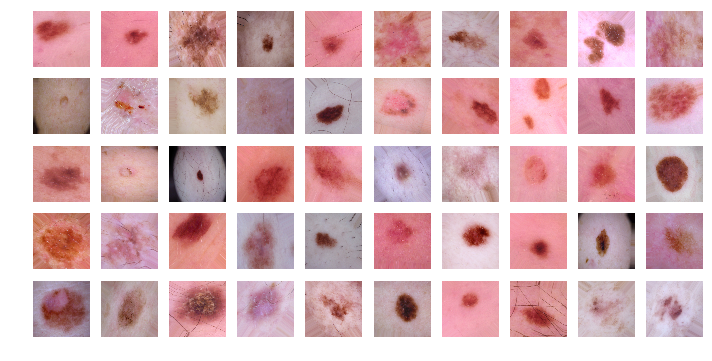

In [36]:
vis_datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

vis_batches = vis_datagen.flow_from_directory(train_dir,
                                            target_size=(image_size,image_size),
                                            batch_size=50)

imgs, labels = next(vis_batches)

# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

#### Prepare model for taining

In [0]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)


In [38]:
CLASSES = 7
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(Adam(lr=0.005), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_norm

**Handle unbalanced_classses**

In [39]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current
class_weight = get_weight(train_batches.classes)
class_weight

array([ 4.30802088,  2.67916175,  1.26632254, 11.89646134,  1.20736898,
        0.21778876,  9.89858233])

In [40]:
filepath = 'sc_model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                    verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint,reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weight,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=5, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/5
70/71 [============================>.] - ETA: 2s - loss: 1.1571 - categorical_accuracy: 0.6497 - top_2_accuracy: 0.7987 - top_3_accuracy: 0.8804
Epoch 00001: val_top_3_accuracy improved from -inf to 0.90405, saving model to sc_model.h5
71/71 [==============================] - 253s 4s/step - loss: 1.1560 - categorical_accuracy: 0.6497 - top_2_accuracy: 0.7982 - top_3_accuracy: 0.8808 - val_loss: 1.3160 - val_categorical_accuracy: 0.8006 - val_top_2_accuracy: 0.8603 - val_top_3_accuracy: 0.9041
Epoch 2/5
70/71 [============================>.] - ETA: 2s - loss: 0.9514 - categorical_accuracy: 0.6816 - top_2_accuracy: 0.8296 - top_3_accuracy: 0.9069
Epoch 00002: val_top_3_accuracy improved from 0.90405 to 0.90618, saving model to sc_model.h5
71/71 [==============================] - 192s 3s/step - loss: 0.9513 - categorical_accuracy: 0.6813 - top_2_accuracy: 0.8292 - top_3_accuracy: 0.9070 - val_loss: 1.3440 - val_categorical_accuracy: 0.8006 - val_top_2_accuracy: 0.8710 - val_top_

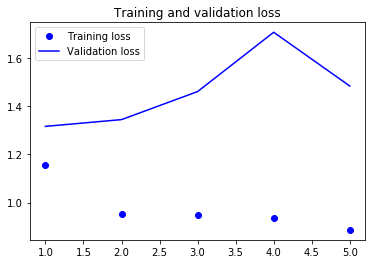

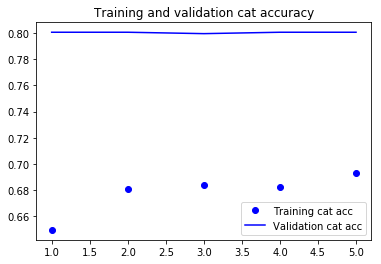

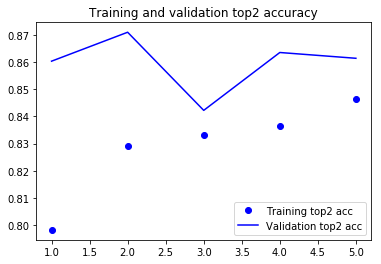

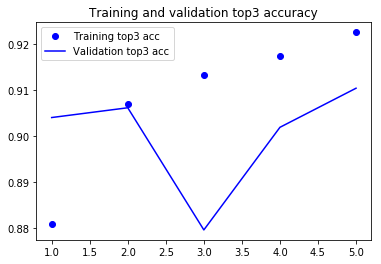

In [43]:

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()